ONNX input name: float_input
ONNX outputs count: 2
Detected direct label output with dtype: int64
Fallback-mapped numeric indices to inferred labels (may be unreliable): {np.int64(0): 'Critical', np.int64(1): 'Warning', np.int64(2): 'Normal'}
=== Evaluation Summary ===
Accuracy: 0.0077
Weighted F1: 0.0136
Macro F1: 0.0053

Per-class F1:
  Critical: 0.0000
  Normal: 0.0137

Classification Report:
               precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        17
     Warning       0.00      0.16      0.00        31
      Normal       0.52      0.01      0.01      6473

    accuracy                           0.01      6521
   macro avg       0.17      0.06      0.01      6521
weighted avg       0.51      0.01      0.01      6521


Confusion Matrix (rows=true, cols=pred ordered by labels_sorted):
 [[   0    1   16]
 [   0    5   26]
 [1775 4653   45]]


,timestamp,devID,soil_mean,rain_mean,temp_mean,humi_mean,geo_mean,geo_std,label,hour,day_of_week,true_label_mapped,predicted_label
0,2025-05-02 11:40:00,101,28.807142,0.0,34.483864,63.477869,10.403310,3.600070,Normal,11,4,Normal,Critical
1,2025-05-02 11:40:00,102,22.200001,0.0,34.717920,62.513730,7.895913,5.625963,Normal,11,4,Normal,Critical
2,2025-05-02 11:50:00,102,22.203572,0.0,34.847077,61.514394,9.278016,7.178730,Normal,11,4,Normal,Critical
3,2025-05-02 11:50:00,101,28.796363,0.0,34.705092,63.005772,11.076278,4.215530,Normal,11,4,Normal,Critical
4,2025-05-02 12:00:00,101,28.757143,0.0,35.428349,63.029602,12.472494,3.210523,Normal,12,4,Normal,Critical


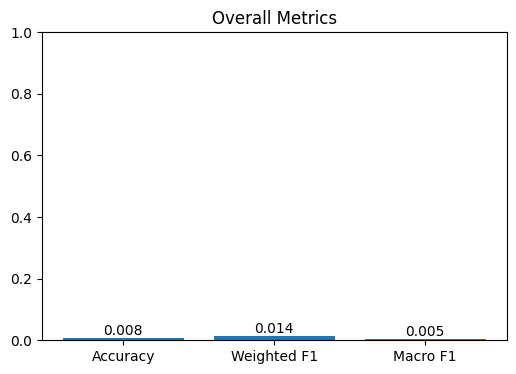

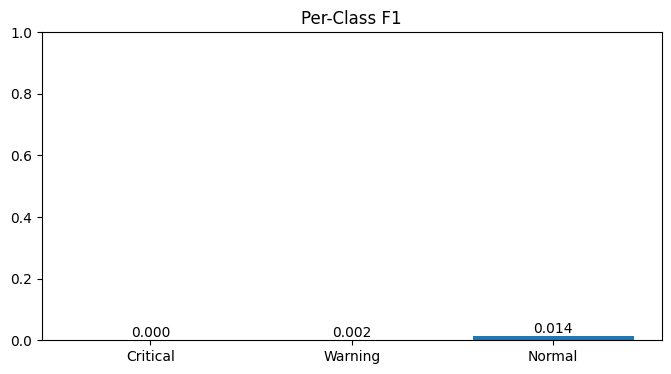

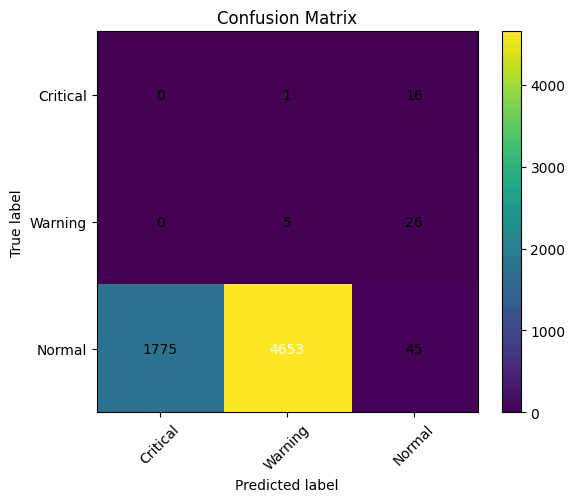

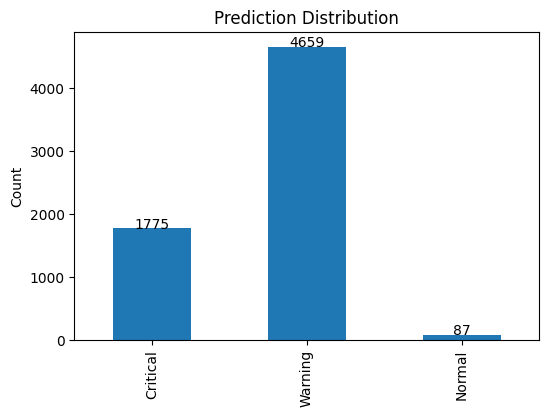

No probability output detected from ONNX; skipping ROC plots.


In [2]:
# Jupyter-ready: evaluate_landslide_onnx (inline plotting, robust handling)
%matplotlib inline

import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_curve, auc
)
import onnxruntime as ort

# === user config ===
onnx_path = "./model/landslide_rf_pipeline.onnx"   # เปลี่ยนเป็น path ของคุณ
scaler_candidates = [
    "./model/landslide_scaler.joblib",
    "./model/landsilde_scaler.joblib",
    "./model/iso_scaler2.joblib",
    "./model/iso_scaler.joblib",
    "./model/scaler.joblib"
]
test_csvs = [
    "./../../data/dev101_resample10T_flex.csv",
    "./../../data/dev102_resample10T_flex.csv"
]
feature_cols = ['soil_mean','rain_mean','temp_mean','humi_mean','geo_mean']
label_col = 'label'  # ปรับถ้าชื่อคอลัมน์จริงต่างออกไป

preferred_order = ['Critical', 'Warning', 'Normal']  # ถ้าต้องการบังคับลำดับป้าย

# === 1. Load data ===
dfs = []
for p in test_csvs:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Test CSV not found: {p}")
    dfs.append(pd.read_csv(p))

df = pd.concat(dfs, ignore_index=True)
if 'timestamp' in df.columns:
    df = df.sort_values('timestamp').reset_index(drop=True)

# เติมค่า label ที่หาย
df[label_col] = df[label_col].fillna('Normal')

# Map labels ให้เป็นชื่อมาตรฐาน (ถ้ามีหลายรูปแบบ)
map_to = {
    'critical': 'Critical',
    'warning': 'Warning',
    'normal': 'Normal',
    'Normal': 'Normal',
    'Critical': 'Critical',
    'Warning': 'Warning'
}
df['true_label_mapped'] = df[label_col].map(map_to).fillna(df[label_col].astype(str))

# ตรวจคอลัมน์ feature
missing = [c for c in feature_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing feature columns in test data: {missing}")

X = df[feature_cols].values
y_true_raw = df['true_label_mapped'].values

# === 2. Optional: load external scaler ===
scaler = None
for path in scaler_candidates:
    if os.path.exists(path):
        try:
            scaler = joblib.load(path)
            print(f"Loaded scaler from: {path}")
            break
        except Exception as e:
            print(f"Found scaler file but failed to load {path}: {e}")
            scaler = None

if scaler is not None:
    try:
        X_input = scaler.transform(X)
    except Exception as e:
        print("Scaler found but transform failed -> assume ONNX handles preprocessing. Error:", e)
        X_input = X.astype(np.float32)
else:
    X_input = X.astype(np.float32)

# === 3. Load ONNX and inference ===
if not os.path.exists(onnx_path):
    raise FileNotFoundError(f"ONNX model not found at: {onnx_path}")

sess = ort.InferenceSession(onnx_path)
input_name = sess.get_inputs()[0].name
print("ONNX input name:", input_name)

X_feed = X_input.astype(np.float32)
onnx_outputs = sess.run(None, {input_name: X_feed})
print("ONNX outputs count:", len(onnx_outputs))

# --- Detect outputs robustly ---
y_pred = None
y_proba = None
onnx_class_labels = None  # ถ้า ONNX เก็บชื่อคลาสเป็น output จะอ่านเก็บที่นี่

def _squeeze_arr(a):
    a = np.array(a)
    if a.ndim == 2 and a.shape[1] == 1:
        return a.ravel()
    return a

# 1) หา probability-like output (n_samples, n_classes)
for out in onnx_outputs:
    a = np.array(out)
    if a.ndim == 2 and a.shape[0] == len(X_feed) and a.shape[1] > 1:
        y_proba = a
        print("Detected probability output with shape:", a.shape)
        break

# 2) หา class-labels vector (n_samples,) เป็น strings หรือ ints
if y_proba is None:
    for out in onnx_outputs:
        a = np.array(out)
        # candidate: length == n_samples
        if a.shape[0] == len(X_feed):
            # treat as direct label output
            y_pred = _squeeze_arr(a)
            print("Detected direct label output with dtype:", a.dtype)
            break

# 3) หากพบ probabilities แต่ยังไม่มีชื่อคลาส ให้หา output ที่อาจเป็นชื่อคลาส (n_classes,)
if y_proba is not None:
    for out in onnx_outputs:
        a = np.array(out)
        if a.ndim == 1 and a.shape[0] == y_proba.shape[1] and a.dtype.kind in {'U','S'}:
            onnx_class_labels = [str(x) for x in a]
            print("Detected class-label names from ONNX output:", onnx_class_labels)
            break

# 4) กรณี probabilities มี แต่ไม่มีชื่อคลาส: สร้าง index labels ชั่วคราว
if y_proba is not None and onnx_class_labels is None:
    onnx_class_labels = [str(i) for i in range(y_proba.shape[1])]
    print("No class names found in ONNX; using index labels:", onnx_class_labels)

# 5) ถ้ามี probabilities ให้สร้าง predicted labels ด้วย argmax
if y_proba is not None:
    y_pred_idx = np.argmax(y_proba, axis=1)
    y_pred = np.array([onnx_class_labels[i] for i in y_pred_idx])

# 6) ถ้ายังไม่มี y_pred ให้ลองใช้เอาต์พุตตัวแรกแล้วแปลงเป็น str/number ตามสมควร
if y_pred is None:
    y_pred = _squeeze_arr(onnx_outputs[0])
    # ถ้าเป็น bytes ให้แปลงเป็น str
    if y_pred.dtype.kind == 'S' or y_pred.dtype.kind == 'b':
        y_pred = y_pred.astype(str)
    # ถ้าเป็น numeric (int/float) ให้เก็บไว้เป็นตัวเลขก่อน (จะแม็ปต่อไป)
    # แต่เพื่อความปลอดภัยแปลงเป็น str ก่อน (จะจัดการ mapping ด้านล่าง)
    y_pred = np.array(y_pred)

# === 4. Normalize dtypes and handle mapping cases ===
# แปลงทั้ง true/pred เป็น string เบื้องต้น (เพื่อหลีกเลี่ยง mixed-type sorting errors)
y_true = np.array(y_true_raw).astype(str)
y_pred_raw = np.array(y_pred)

# ถ้า y_pred เป็น bytes -> str
if y_pred_raw.dtype.kind == 'S' or y_pred_raw.dtype.kind == 'b':
    y_pred_str = y_pred_raw.astype(str)
else:
    y_pred_str = y_pred_raw.astype(str)

# ตรวจว่าค่า y_pred จริงๆเป็นตัวเลข index หรือชื่อคลาส
is_all_digits = np.all([s.isdigit() for s in y_pred_str])
if is_all_digits:
    # แปลงกลับเป็น ints
    y_pred_idx = y_pred_str.astype(int)
    if onnx_class_labels is not None and len(onnx_class_labels) > 0:
        # ถ้ามีชื่อคลาสจาก ONNX ใช้แม็ป
        try:
            y_pred_mapped = np.array([onnx_class_labels[i] for i in y_pred_idx])
            y_pred_final = y_pred_mapped.astype(str)
            print("Mapped numeric prediction indices to ONNX class labels.")
        except Exception as e:
            print("Failed to map numeric indices -> class labels using onnx_class_labels:", e)
            # fallback: map to preferred_order or to unique true labels if lengths match
            y_pred_final = y_pred_str
    else:
        # ไม่มีชื่อคลาสจาก ONNX: พยายามเดาแม็ปโดย match unique counts (risky but fallback)
        unique_true = np.unique(y_true)
        unique_pred_idx = np.unique(y_pred_idx)
        if len(unique_pred_idx) == len(unique_true):
            # map sorted indices -> preferred labels (preferred_order first)
            if set(preferred_order).issuperset(set(unique_true)):
                # use preferred order intersection
                labels_map = {idx: lab for idx, lab in zip(sorted(unique_pred_idx), [lab for lab in preferred_order if lab in unique_true])}
            else:
                labels_map = {idx: lab for idx, lab in zip(sorted(unique_pred_idx), sorted(unique_true))}
            y_pred_final = np.array([labels_map.get(i, str(i)) for i in y_pred_idx]).astype(str)
            print("Fallback-mapped numeric indices to inferred labels (may be unreliable):", labels_map)
        else:
            # ไม่สามารถแม็ปได้ -> เก็บเป็น str ของตัวเลข
            y_pred_final = y_pred_str
            print("Predictions are numeric indices but no class names available; keeping numeric string labels.")
else:
    # ถ้า y_pred_str คือชื่อคลาส (ไม่ใช่ตัวเลข) ให้ใช้เลย
    y_pred_final = y_pred_str.astype(str)

# สุดท้าย: ensure lengths match
if len(y_pred_final) != len(y_true):
    raise ValueError("Predicted labels length does not match true labels length after processing.")

# === 5. Compute metrics (with consistent label ordering) ===
# สร้าง labels_sorted โดยเอา preferred_order มาใส่ก่อนถ้ามี
labels_present = list(np.unique(np.concatenate([y_true, y_pred_final])))
labels_sorted = [lab for lab in preferred_order if lab in labels_present] + \
                [lab for lab in sorted(labels_present) if lab not in preferred_order]

# ถ้าอยากไม่บังคับ order ให้ใช้บรรทัดนี้แทน:
# labels_sorted = sorted(np.unique(np.concatenate([y_true, y_pred_final])))

acc = accuracy_score(y_true, y_pred_final)
f1_weighted = f1_score(y_true, y_pred_final, average='weighted', labels=labels_sorted, zero_division=0)
f1_macro = f1_score(y_true, y_pred_final, average='macro', labels=labels_sorted, zero_division=0)
f1_per_class = f1_score(y_true, y_pred_final, average=None, labels=labels_sorted, zero_division=0)
clf_report = classification_report(y_true, y_pred_final, labels=labels_sorted, zero_division=0)
cm = confusion_matrix(y_true, y_pred_final, labels=labels_sorted)

print("=== Evaluation Summary ===")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1_weighted:.4f}")
print(f"Macro F1: {f1_macro:.4f}")
print("\nPer-class F1:")
for lab, f in zip(labels_sorted, f1_per_class):
    print(f"  {lab}: {f:.4f}")
print("\nClassification Report:\n", clf_report)
print("\nConfusion Matrix (rows=true, cols=pred ordered by labels_sorted):\n", cm)

# Add predictions to dataframe and show preview
df['predicted_label'] = y_pred_final
display(df.head())

# === 6. Visualizations (inline separate plots) ===
# Plot A: Accuracy and F1 summary
fig, ax = plt.subplots(figsize=(6,4))
metrics_names = ['Accuracy', 'Weighted F1', 'Macro F1']
metrics_vals = [acc, f1_weighted, f1_macro]
ax.bar(metrics_names, metrics_vals)
ax.set_ylim(0,1)
for i,v in enumerate(metrics_vals):
    ax.text(i, v+0.01, f"{v:.3f}", ha='center')
ax.set_title("Overall Metrics")
plt.show()

# Plot B: Per-class F1
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(labels_sorted, f1_per_class)
ax.set_ylim(0,1)
ax.set_title("Per-Class F1")
for i,v in enumerate(f1_per_class):
    ax.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.show()

# Plot C: Confusion matrix heatmap (simple matplotlib)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(labels_sorted)))
ax.set_yticks(np.arange(len(labels_sorted)))
ax.set_xticklabels(labels_sorted, rotation=45)
ax.set_yticklabels(labels_sorted)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confusion Matrix')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# Plot D: Prediction distribution (counts)
pred_counts = pd.Series(y_pred_final).value_counts().reindex(labels_sorted, fill_value=0)
fig, ax = plt.subplots(figsize=(6,4))
pred_counts.plot(kind='bar', ax=ax)
ax.set_title("Prediction Distribution")
ax.set_ylabel("Count")
for i, v in enumerate(pred_counts.values):
    ax.text(i, v+1, str(v), ha='center')
plt.show()

# Plot E: ROC curves if probabilities exist and match classes
if y_proba is not None:
    lb_classes = labels_sorted
    try:
        y_true_bin = label_binarize(y_true, classes=lb_classes)
        if y_true_bin.ndim == 1:
            y_true_bin = y_true_bin.reshape(-1,1)
        if y_proba.shape[1] == len(lb_classes):
            fig = plt.figure(figsize=(8,6))
            for i, lab in enumerate(lb_classes):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{lab} (AUC = {roc_auc:.2f})')
            plt.plot([0,1], [0,1], linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves (one-vs-rest)')
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.show()
        else:
            print("Probability output shape does not match number of classes; skipping ROC plots.")
    except Exception as e:
        print("Failed to plot ROC curves:", e)
else:
    print("No probability output detected from ONNX; skipping ROC plots.")
